In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def process_data(filepath):
    """
    Reads and cleans the batting split data from the given file.

    This function handles file loading, filters for 'Batting' splits,
    converts necessary columns to numeric types, and calculates the
    'RC_per_PA' statistic.

    Args:
        filepath (str): The path to the data file.

    Returns:
        pd.DataFrame: A cleaned and processed DataFrame with RC/PA,
                      or None if an error occurs during file processing.
    """
    
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        return None
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        return None

    # --- Data Cleaning and Filtering ---
    # Filter for rows related to individual batting splits
    batting_df = df[df['Split'].str.startswith('Batting', na=False)].copy()

    # Convert relevant columns to numeric, coercing errors to NaN
    for col in ['Year', 'RC', 'PA']:
        batting_df[col] = pd.to_numeric(batting_df[col], errors='coerce')

    # Drop rows where essential data is missing
    batting_df.dropna(subset=['Year', 'RC', 'PA'], inplace=True)

    # Calculate Runs Created per Plate Appearance (RC/PA)
    batting_df = batting_df[batting_df['PA'] != 0].copy()
    batting_df['RC_per_PA'] = batting_df['RC'] / batting_df['PA']

    # Ensure 'Year' is an integer type
    batting_df['Year'] = batting_df['Year'].astype(int)

    return batting_df

In [3]:
def create_red_sox_plots(df):
    """
    Generates and displays a 3x3 grid of subplots for each batting split,
    showing RC/PA over time.

    Args:
        df (pd.DataFrame): The processed DataFrame containing batting data.
    """

    analysis_df = df.copy()

    unique_splits = sorted(analysis_df['Split'].unique())

    if not unique_splits:
        print("No data rows found to plot for the given criteria.")
        return

    nrows, ncols = 3, 3
    _, axes = plt.subplots(nrows, ncols, figsize=(18, 15))

    # Flatten the 2D axes array into a 1D array for easy iteration
    axes = axes.flatten()

    # Loop through each split and its corresponding subplot axis
    for i, split in enumerate(unique_splits):
        ax = axes[i]
        split_data = analysis_df[analysis_df['Split'] == split]

        # Ensure there are at least two data points to create a line
        if split_data.shape[0] < 2:
            print(f"Skipping plot for '{split}' due to insufficient data points.")
            ax.set_title(f"'{split}'\n(Not enough data)")
            ax.axis('off') # Hide axis for empty plot
            continue

        x_axis = split_data['Year']
        y_axis = split_data['RC_per_PA']

        m, b = np.polyfit(x_axis, y_axis, 1)

        # Create the scatter plot and the best-fit line on the specific subplot
        ax.scatter(x_axis, y_axis, label='Actual RC/PA Data', color='royalblue', alpha=0.8)
        ax.plot(x_axis, m * x_axis + b, color='red', linewidth=2, label=f'Fit (y={m:.4f}x + {b:.4f})')

        # Format the subplot
        ax.set_title(f"RC/PA vs Year", fontsize=12, weight='bold')
        ax.set_xlabel("Year", fontsize=10)
        ax.set_ylabel("RC per Plate Appearance", fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.tick_params(axis='x', rotation=45, labelsize=9)
        ax.tick_params(axis='y', labelsize=9)
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=6))

    # Turn off any unused subplots in the grid
    for j in range(len(unique_splits), len(axes)):
        axes[j].axis('off')

    # Adjust layout to prevent titles and labels from overlapping
    plt.tight_layout(pad=3.0)

    plt.show()

In [4]:
def create_summary_table(df, start_years):
    """
    Calculates trendline gradients for different start years and prints a summary table.

    Args:
        df (pd.DataFrame): The processed DataFrame containing batting data.
        start_years (list of int): A list of years to use as starting points for trend analysis.
    """
    summary_data = {}
    all_splits = sorted(df['Split'].unique())

    # Calculate gradients for each defined start year period
    for year in start_years:
        yearly_gradients = {}
        period_df = df[df['Year'] >= year]

        for split in all_splits:
            split_data = period_df[period_df['Split'] == split]

            # Calculate gradient only if there's enough data for a line
            if split_data.shape[0] >= 2:
                m, _ = np.polyfit(split_data['Year'], split_data['RC_per_PA'], 1)
                yearly_gradients[split] = m
            else:
                yearly_gradients[split] = np.nan  # Use NaN for insufficient data

        summary_data[f'Gradient ({year}-Present)'] = yearly_gradients

    summary_df = pd.DataFrame(summary_data, index=all_splits)
    summary_df.index.name = 'Batting Split'

    print("\n--- Summary of Gradients (Trend of RC/PA over Different Periods) ---")
    print(summary_df.to_string(float_format="{:+.6f}".format))

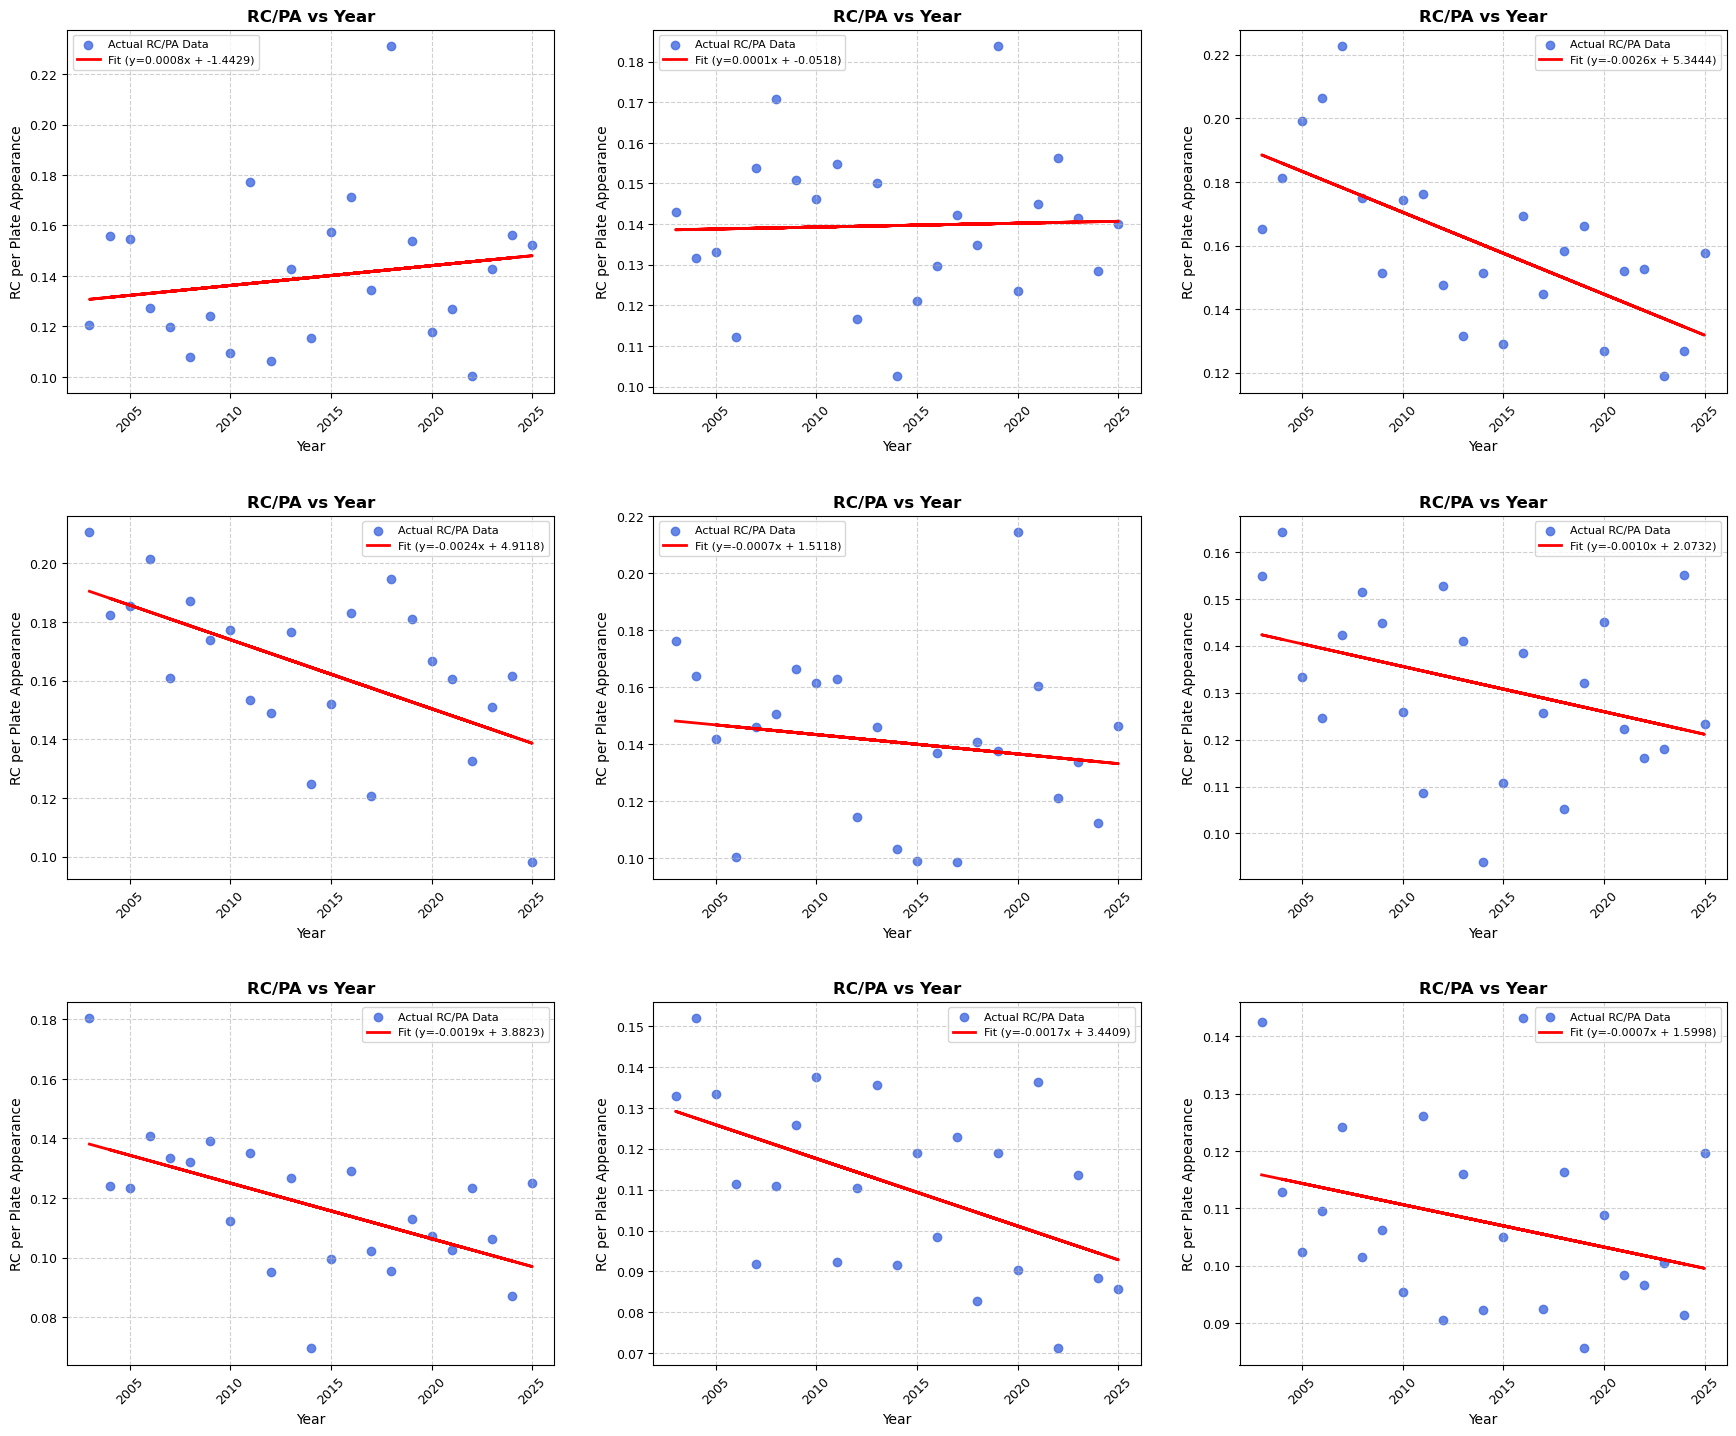


--- Summary of Gradients (Trend of RC/PA over Different Periods) ---
               Gradient (2003-Present)  Gradient (2008-Present)  Gradient (2013-Present)  Gradient (2018-Present)
Batting Split                                                                                                    
Batting 1st                  +0.000786                +0.001253                -0.000756                -0.005826
Batting 2nd                  +0.000095                -0.000388                +0.001234                -0.002083
Batting 3rd                  -0.002574                -0.001544                -0.000394                -0.002650
Batting 4th                  -0.002357                -0.001956                -0.002154                -0.010096
Batting 5th                  -0.000681                -0.000566                +0.001844                -0.004396
Batting 6th                  -0.000964                -0.000440                +0.001074                +0.001853
Batting 7th       

In [5]:
file_path = 'data/redsox_2003_2025_splits.csv'

# Define the start years to be used as columns in the summary table
summary_start_years = [2003, 2008, 2013, 2018]

# 1. Load and process the data
processed_df = process_data(file_path)

if processed_df is not None and not processed_df.empty:
    # 2. Create and display plots
    create_red_sox_plots(processed_df)

    # 3. Create and print the summary table with multiple trend periods
    create_summary_table(processed_df, summary_start_years)
else:
    print("Analysis could not be completed due to data processing errors.")

In [6]:
def create_league_wide_plots(df):
    """
    Generates and displays a plot for each batting split,
    showing RC/PA over time.

    Args:
        df (pd.DataFrame): The processed DataFrame containing batting data.
    """

    analysis_df = df.copy()

    unique_splits = sorted(analysis_df['Split'].unique())

    if not unique_splits:
        print("No data rows found to plot for the given criteria.")
        return

    for split in unique_splits:
        plt.figure(figsize=(10, 6))
        ax = plt.gca()

        split_data = analysis_df[analysis_df['Split'] == split]
        bos_data = split_data[split_data['Team'] == 'BOS']

        if split_data.shape[0] < 2:
            print(f"Skipping plot for '{split}' due to insufficient data points.")
            continue

        # General scatter plot and trendline
        x_axis_all = split_data['Year']
        y_axis_all = split_data['RC_per_PA']
        m_all, b_all = np.polyfit(x_axis_all, y_axis_all, 1)

        ax.scatter(x_axis_all, y_axis_all, label='All Teams RC/PA', color='royalblue', alpha=0.6)
        ax.plot(x_axis_all, m_all * x_axis_all + b_all, color='blue', linewidth=2, label=f'All Teams Trend (y={m_all:.4f}x + {b_all:.4f})')

        # BOS-specific scatter plot and trendline
        if bos_data.shape[0] >= 2:
            x_axis_bos = bos_data['Year']
            y_axis_bos = bos_data['RC_per_PA']
            m_bos, b_bos = np.polyfit(x_axis_bos, y_axis_bos, 1)
            ax.scatter(x_axis_bos, y_axis_bos, color='red', label='BOS RC/PA')
            ax.plot(x_axis_bos, m_bos * x_axis_bos + b_bos, color='red', linestyle='--', linewidth=2, label=f'BOS Trend (y={m_bos:.4f}x + {b_bos:.4f})')

        ax.set_title(f"RC/PA vs Year for {split}", fontsize=14, weight='bold')
        ax.set_xlabel("Year", fontsize=12)
        ax.set_ylabel("RC per Plate Appearance", fontsize=12)
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

        plt.tight_layout()
        plt.show()

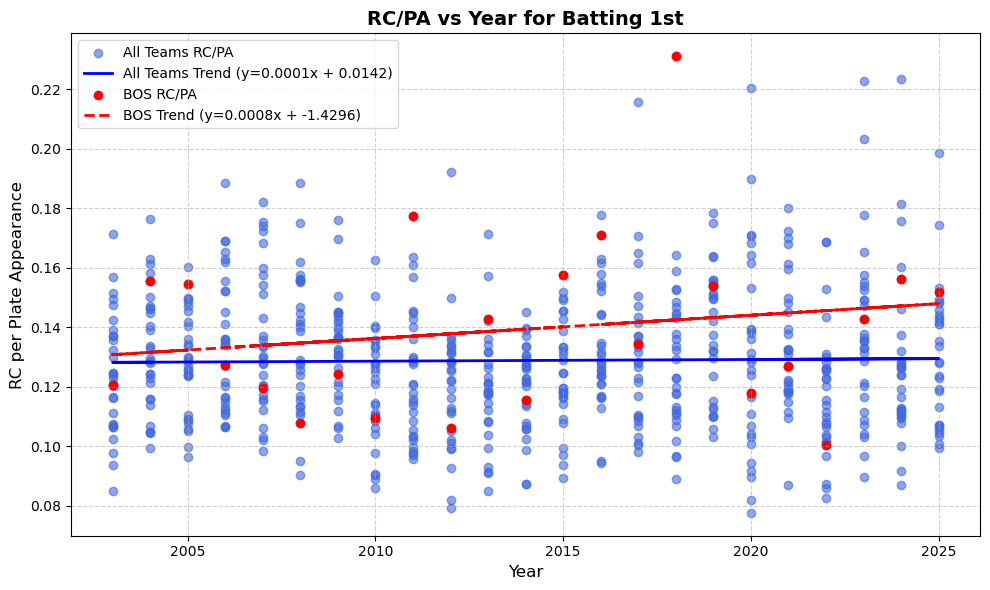

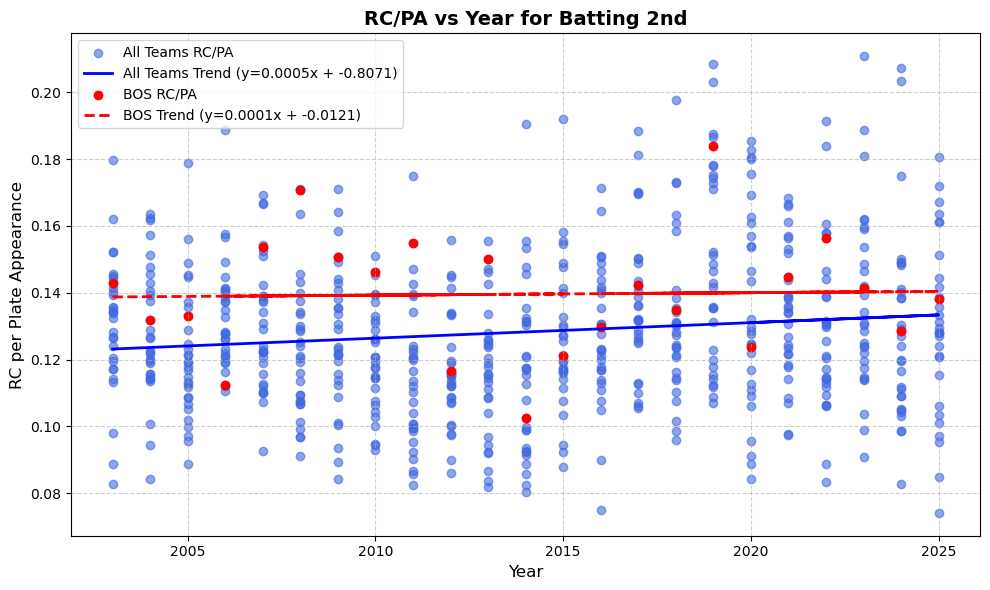

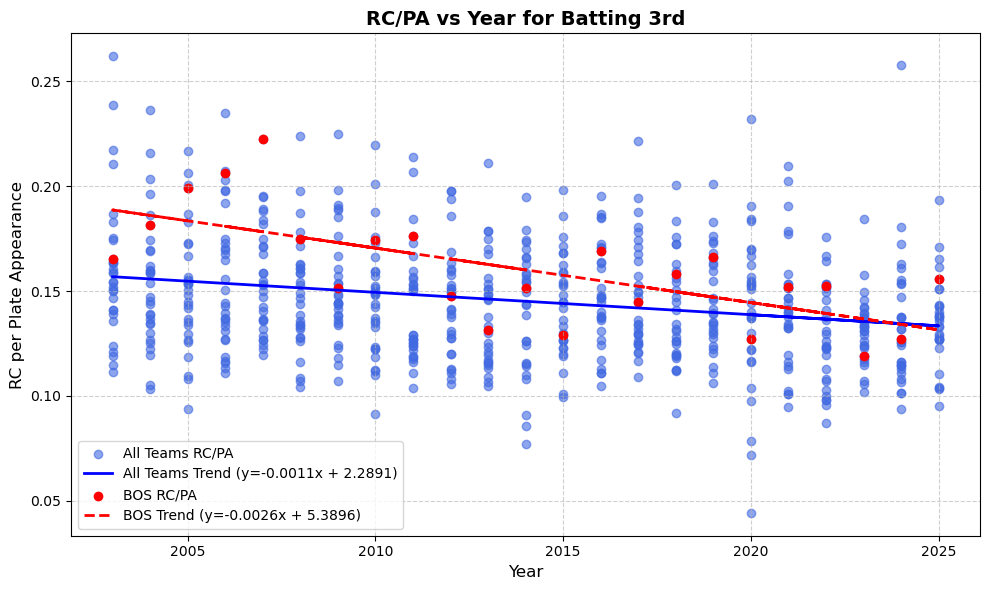

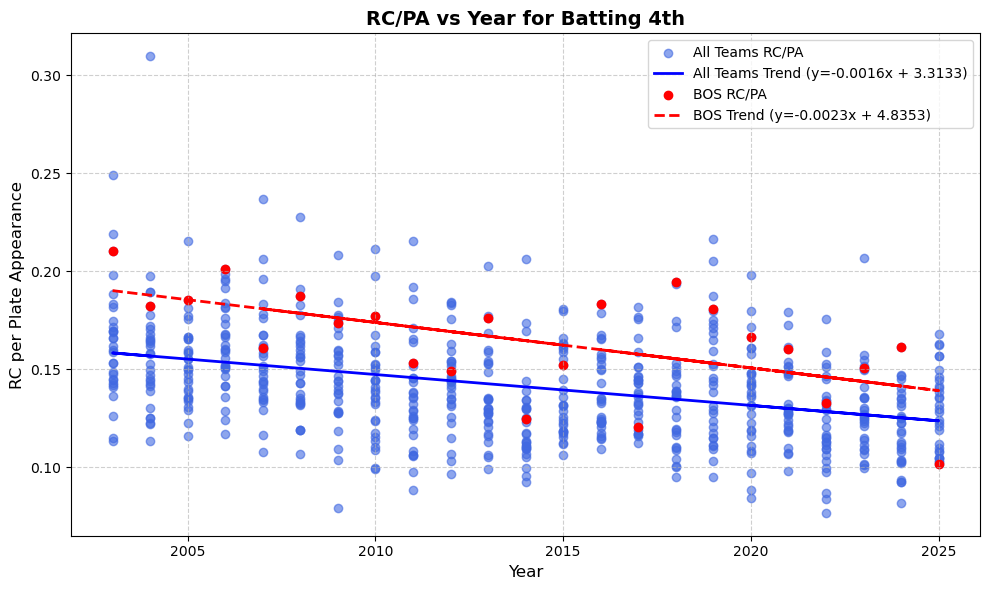

In [7]:
file_names = [
    "data/league-wide/bat_1st_2003_2005_splits.csv", "data/league-wide/bat_1st_2006_2025_splits.csv", "data/league-wide/bat_1st_2016_2025_splits.csv",
    "data/league-wide/bat_2nd_2003_2005_splits.csv", "data/league-wide/bat_2nd_2006_2015_splits.csv", "data/league-wide/bat_2nd_2016_2025_splits.csv",
    "data/league-wide/bat_3rd_2003_2005_splits.csv", "data/league-wide/bat_3rd_2006_2015_splits.csv", "data/league-wide/bat_3rd_2016_2025_splits.csv",
    "data/league-wide/bat_4th_2003_2005_splits.csv", "data/league-wide/bat_4th_2006_2015_splits.csv", "data/league-wide/bat_4th_2016_2025_splits.csv"
]

processed_dfs = [process_data(name) for name in file_names]
# Filter out None values from processed_dfs
processed_dfs = [df for df in processed_dfs if df is not None]

if processed_dfs:
    combined_df = pd.concat(processed_dfs, ignore_index=True)
    create_league_wide_plots(combined_df)
else:
    print("No data could be processed because the files were not found.")

In [8]:
def create_comparison_table(df, start_years):
    """
    Calculates and compares trendline gradients for the entire league and the Red Sox,
    presenting the results in a more readable, multi-level table.

    Args:
        df (pd.DataFrame): The processed DataFrame containing batting data.
        start_years (list of int): A list of years to use as starting points for trend analysis.
    """
    all_splits = sorted(df['Split'].unique())
    bos_df = df[df['Team'] == 'BOS']

    # Create a list of tuples for the multi-level columns
    header = pd.MultiIndex.from_product(
        [[f'{year}-Present' for year in start_years], ['League', 'Red Sox']],
        names=['Period', 'Gradient']
    )
    summary_df = pd.DataFrame(index=all_splits, columns=header)
    summary_df.index.name = 'Batting Split'

    for year in start_years:
        period_df_league = df[df['Year'] >= year]
        period_df_bos = bos_df[bos_df['Year'] >= year]

        for split in all_splits:
            # League-wide gradient
            split_data_league = period_df_league[period_df_league['Split'] == split]
            if split_data_league.shape[0] >= 2:
                m_league, _ = np.polyfit(split_data_league['Year'], split_data_league['RC_per_PA'], 1)
                summary_df.loc[split, (f'{year}-Present', 'League')] = m_league
            else:
                summary_df.loc[split, (f'{year}-Present', 'League')] = np.nan

            # Red Sox gradient
            split_data_bos = period_df_bos[period_df_bos['Split'] == split]
            if split_data_bos.shape[0] >= 2:
                m_bos, _ = np.polyfit(split_data_bos['Year'], split_data_bos['RC_per_PA'], 1)
                summary_df.loc[split, (f'{year}-Present', 'Red Sox')] = m_bos
            else:
                summary_df.loc[split, (f'{year}-Present', 'Red Sox')] = np.nan

    print("\n--- Comparison of Gradients (League vs Red Sox) ---")
    print(summary_df.to_string(float_format="{:+.6f}".format))

In [9]:
def create_delta_table(df, start_years):
    """
    Calculates the difference between the Red Sox and league-wide trendline gradients.

    Args:
        df (pd.DataFrame): The processed DataFrame containing batting data.
        start_years (list of int): A list of years to use as starting points for trend analysis.
    """
    summary_data = {}
    all_splits = sorted(df['Split'].unique())
    bos_df = df[df['Team'] == 'BOS']

    for year in start_years:
        period_differences = {}
        period_df_league = df[df['Year'] >= year]
        period_df_bos = bos_df[bos_df['Year'] >= year]

        for split in all_splits:
            split_data_league = period_df_league[period_df_league['Split'] == split]
            split_data_bos = period_df_bos[period_df_bos['Split'] == split]

            if split_data_league.shape[0] >= 2 and split_data_bos.shape[0] >= 2:
                m_league, _ = np.polyfit(split_data_league['Year'], split_data_league['RC_per_PA'], 1)
                m_bos, _ = np.polyfit(split_data_bos['Year'], split_data_bos['RC_per_PA'], 1)
                period_differences[split] = m_bos - m_league
            else:
                period_differences[split] = np.nan

        summary_data[f'Delta ({year}-Present)'] = period_differences

    summary_df = pd.DataFrame(summary_data, index=all_splits)
    summary_df.index.name = 'Batting Split'

    print("\n--- Gradient Difference (Red Sox Trend - League Trend) ---")
    print(summary_df.to_string(float_format="{:+.6f}".format))

In [10]:
def create_delta_plus_table(df, start_years):
    """
    Calculates the percentage difference between the Red Sox and league-wide trendline gradients.

    Args:
        df (pd.DataFrame): The processed DataFrame containing batting data.
        start_years (list of int): A list of years to use as starting points for trend analysis.
    """
    summary_data = {}
    all_splits = sorted(df['Split'].unique())
    bos_df = df[df['Team'] == 'BOS']

    for year in start_years:
        period_percentages = {}
        period_df_league = df[df['Year'] >= year]
        period_df_bos = bos_df[bos_df['Year'] >= year]

        for split in all_splits:
            split_data_league = period_df_league[period_df_league['Split'] == split]
            split_data_bos = period_df_bos[period_df_bos['Split'] == split]

            if split_data_league.shape[0] >= 2 and split_data_bos.shape[0] >= 2:
                m_league, _ = np.polyfit(split_data_league['Year'], split_data_league['RC_per_PA'], 1)
                m_bos, _ = np.polyfit(split_data_bos['Year'], split_data_bos['RC_per_PA'], 1)
                
                if m_league != 0:
                    percentage_diff = ((m_bos / m_league) - 1) * 100
                    period_percentages[split] = percentage_diff
                else:
                    period_percentages[split] = np.inf
            else:
                period_percentages[split] = np.nan

        summary_data[f'Delta+ ({year}-Present)'] = period_percentages

    summary_df = pd.DataFrame(summary_data, index=all_splits)
    summary_df.index.name = 'Batting Split'

    print("\n--- Gradient Percentage Difference ([(Red Sox / League) - 1] %) ---")
    print(summary_df.to_string(float_format="{:.2f}".format))

In [11]:
create_summary_table(combined_df, summary_start_years)
create_comparison_table(combined_df, summary_start_years)
create_delta_table(combined_df, summary_start_years)
create_delta_plus_table(combined_df, summary_start_years)


--- Summary of Gradients (Trend of RC/PA over Different Periods) ---
               Gradient (2003-Present)  Gradient (2008-Present)  Gradient (2013-Present)  Gradient (2018-Present)
Batting Split                                                                                                    
Batting 1st                  +0.000057                +0.000355                +0.000638                -0.000480
Batting 2nd                  +0.000464                +0.001035                +0.001058                -0.001342
Batting 3rd                  -0.001065                -0.000888                -0.000948                -0.001530
Batting 4th                  -0.001575                -0.001147                -0.000877                -0.002375

--- Comparison of Gradients (League vs Red Sox) ---
Period        2003-Present           2008-Present           2013-Present           2018-Present          
Gradient            League   Red Sox       League   Red Sox       League   Red Sox     